# Idiosyncratic Momentum Panel Testing (4H Data)

This notebook tests the EWMA-based idiosyncratic momentum indicators from `src/slipstream/signals/` using **4H candle data** and **4H-aligned PCA factors**.

**Key Features:**
- Uses 4H candles and 4H-aligned PCA factors (H ∈ {4, 8, 12, 16, 20, 24, 48})
- Computes momentum panel with multiple EWMA spans (idio_mom_2, idio_mom_4, idio_mom_8, etc.)
- EWMA provides exponentially-weighted momentum vs. simple rolling sums
- Multi-timescale analysis for feature engineering

**Objectives:**
1. Compute momentum panel for multiple spans
2. Visualize momentum at different timescales
3. Analyze cross-timescale momentum patterns
4. Export momentum features for modeling

**Data:**
- Base interval: 4H candles (~2.3 years of data, 184 assets)
- PCA factors: Timescale-matched with K=30 lookback multiplier

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

# Import signal functions
from slipstream.signals import (
    idiosyncratic_momentum,
    compute_idiosyncratic_returns,
    normalize_signal_cross_sectional,
)

# Plotting setup
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ Imports successful")

✓ Imports successful


## 1. Data Loading

In [ ]:
def load_all_returns(data_dir='../data/market_data', interval='4h'):
    """Load all candle files and compute log returns."""
    data_path = Path(data_dir)
    pattern = f'*_candles_{interval}.csv'
    candle_files = sorted(data_path.glob(pattern))
    
    print(f"Looking for pattern: {pattern}")
    print(f"Found {len(candle_files)} files")
    
    returns_dict = {}
    
    for file in candle_files:
        coin = file.stem.replace(f'_candles_{interval}', '')
        df = pd.read_csv(file)
        
        # Handle both 'datetime' and 'timestamp' column names
        if 'datetime' in df.columns:
            df.index = pd.to_datetime(df['datetime'])
        elif 'timestamp' in df.columns:
            df.index = pd.to_datetime(df['timestamp'])
        else:
            continue
        
        df = df.sort_index()
        if 'close' in df.columns:
            log_returns = np.log(df['close'] / df['close'].shift(1))
            returns_dict[coin] = log_returns
    
    returns_df = pd.DataFrame(returns_dict)
    returns_df = returns_df.sort_index()
    
    print(f"Loaded returns for {len(returns_df.columns)} assets")
    print(f"Date range: {returns_df.index.min()} to {returns_df.index.max()}")
    print(f"Shape: {returns_df.shape}")
    print(f"NaN percentage: {(returns_df.isna().sum().sum() / returns_df.size * 100):.2f}%")
    
    return returns_df

def load_pca_factor(H=24, K=30, weight_method='sqrt', features_dir='../data/features'):
    """Load PCA factor file and compute PC1 returns (market factor).
    
    The market factor return at each timestamp is computed as the weighted sum
    of asset returns using the PC1 loadings as weights:
        R_m(t) = sum_i [loading_i(t) * return_i(t)]
    
    This is the standard way to compute principal component returns.
    """
    features_path = Path(features_dir)
    filename = f'pca_factor_H{H}_K{K}_{weight_method}.csv'
    filepath = features_path / filename
    
    if not filepath.exists():
        raise FileNotFoundError(f"PCA factor file not found: {filepath}")
    
    # Load wide format PCA data
    pca_wide = pd.read_csv(filepath, index_col=0)
    pca_wide.index = pd.to_datetime(pca_wide.index)
    pca_wide.index.name = 'timestamp'
    
    # Drop metadata columns
    metadata_cols = ['_variance_explained', '_n_assets']
    asset_cols = [col for col in pca_wide.columns if col not in metadata_cols]
    
    # Convert to long format (timestamp, asset) -> loading
    loadings_wide = pca_wide[asset_cols]
    loadings_long = loadings_wide.stack()
    loadings_long.index.names = ['timestamp', 'asset']
    
    print(f"Loaded PCA factor: H={H}, K={K}, method={weight_method}")
    print(f"Assets: {len(asset_cols)}, Timestamps: {len(pca_wide)}")
    print(f"Date range: {pca_wide.index.min()} to {pca_wide.index.max()}")
    
    return loadings_long, loadings_wide, pca_wide

def compute_market_factor(loadings_wide, returns):
    """Compute PC1 returns (market factor) from loadings and returns.
    
    Args:
        loadings_wide: DataFrame with timestamp index and asset columns (PC1 loadings)
        returns: DataFrame with timestamp index and asset columns (returns)
    
    Returns:
        Series with timestamp index containing PC1 returns (R_m)
    """
    # Align timestamps between loadings and returns
    common_timestamps = loadings_wide.index.intersection(returns.index)
    loadings_aligned = loadings_wide.loc[common_timestamps]
    returns_aligned = returns.loc[common_timestamps]
    
    # Align asset columns (handle assets that may not be in both)
    common_assets = loadings_aligned.columns.intersection(returns_aligned.columns)
    loadings_aligned = loadings_aligned[common_assets]
    returns_aligned = returns_aligned[common_assets]
    
    # Compute market factor: R_m(t) = sum_i [loading_i(t) * return_i(t)]
    # This is element-wise multiplication summed across assets for each timestamp
    market_factor = (loadings_aligned * returns_aligned).sum(axis=1, skipna=True)
    
    print(f"\nComputed market factor (PC1 returns):")
    print(f"  Timestamps: {len(market_factor)}")
    print(f"  Mean: {market_factor.mean():.6f}")
    print(f"  Std:  {market_factor.std():.6f}")
    print(f"  Min:  {market_factor.min():.6f}")
    print(f"  Max:  {market_factor.max():.6f}")
    
    return market_factor

# Load 4H candle data
print("Loading 4H candle data...")
returns = load_all_returns(interval='4h')

# Load 4H-aligned PCA factor (H=24 corresponds to 24 hours = 6 periods of 4H candles)
print("\nLoading PCA factor...")
loadings_24h_long, loadings_24h_wide, pca_df_24h = load_pca_factor(H=24, K=30, weight_method='sqrt')

# Compute actual market factor (PC1 returns) from loadings and returns
market_24h = compute_market_factor(loadings_24h_wide, returns)

## 1.5 Volatility Normalization Test

Check how volatility normalization transforms idiosyncratic returns to be more white noise-ish.

Computing idiosyncratic returns...
Using vol_span = 16 periods (= 8*2, same as signals module)
BTC idiosyncratic returns: 802 observations
After vol normalization: 795 observations


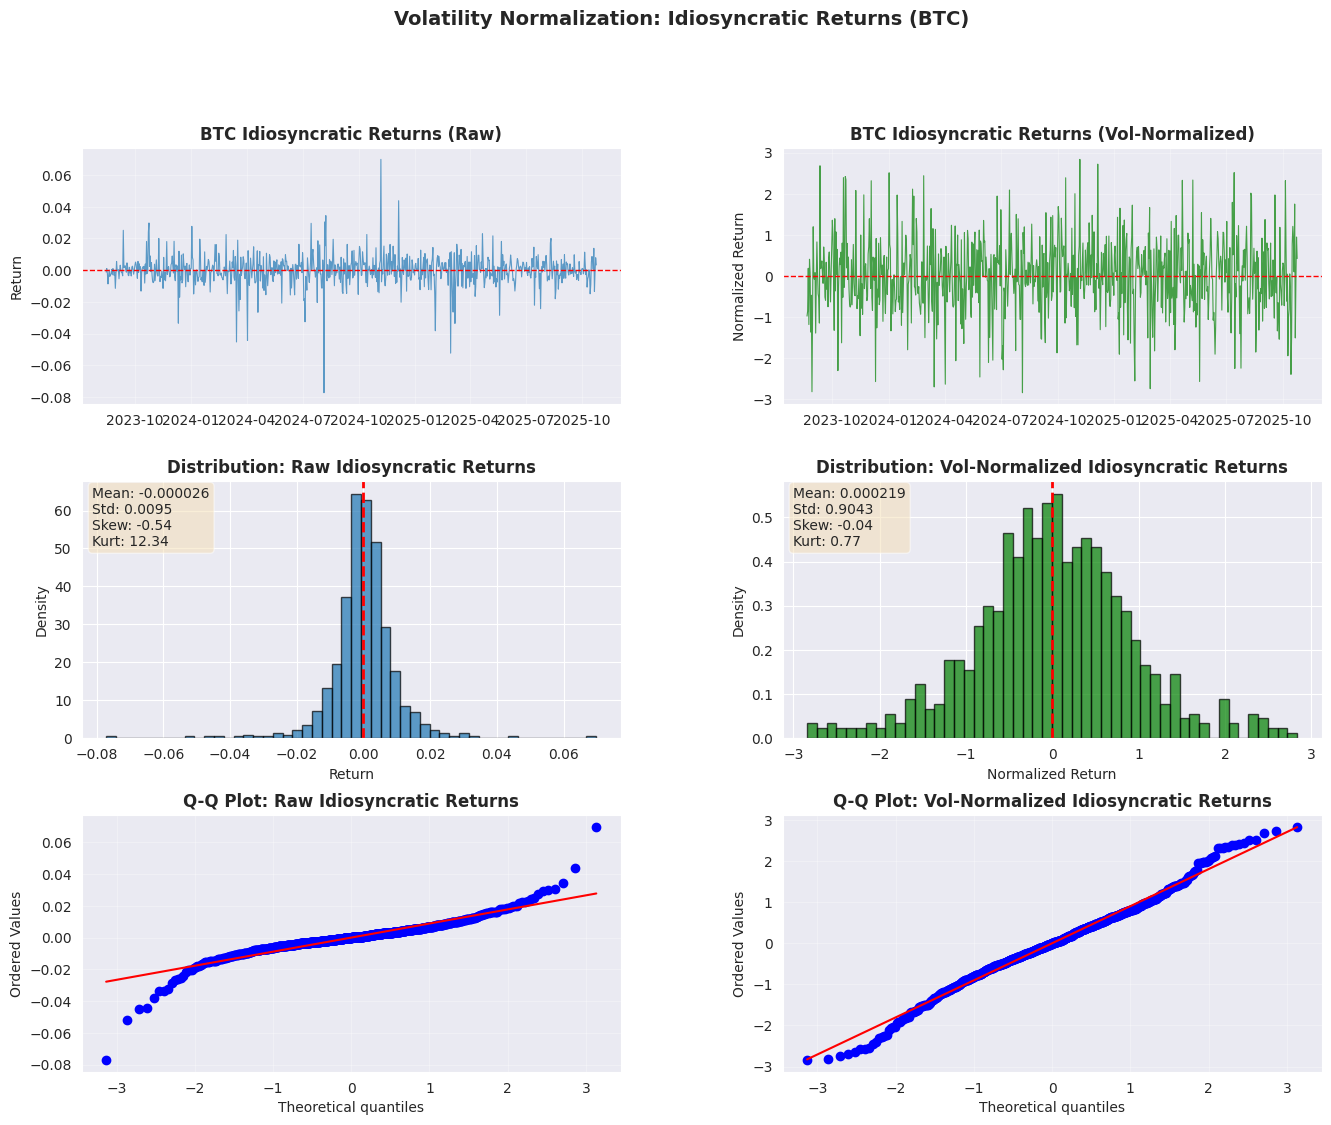


Observations:
- Idiosyncratic returns = residuals after removing market factor (PC1)
- Vol-normalization uses SAME logic as signals.idiosyncratic_momentum()
- Should make variance more constant over time (homoskedastic)
- Q-Q plot closer to diagonal = more Gaussian/white noise-ish
- Kurtosis reduced = fewer extreme outliers
- This is the signal used for momentum prediction!


In [3]:
# First compute idiosyncratic returns (remove market factor)
print("Computing idiosyncratic returns...")
idio_returns = compute_idiosyncratic_returns(returns, loadings_24h, market_24h)

# Select BTC idiosyncratic returns for visualization
btc_idio = idio_returns['BTC'].dropna()

# Compute volatility-normalized idiosyncratic returns using the SAME logic as signals module
# (see src/slipstream/signals/idiosyncratic_momentum.py lines 136-143)
test_span = 8  # Example span we'll use for demonstration
vol_span = test_span * 2  # Same as signals module: vol_span = max(spans) * 2

# EWMA volatility (exactly as in signals module)
btc_vol = btc_idio.ewm(span=vol_span, min_periods=vol_span // 2).std()
btc_vol = btc_vol.replace(0, np.nan)  # Avoid division by zero

# Normalize by volatility (exactly as in signals module)
btc_normalized = btc_idio / btc_vol

# Drop NaN values
btc_normalized = btc_normalized.dropna()

print(f"Using vol_span = {vol_span} periods (= {test_span}*2, same as signals module)")
print(f"BTC idiosyncratic returns: {len(btc_idio)} observations")
print(f"After vol normalization: {len(btc_normalized)} observations")

# Create figure with 6 subplots
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Time series - Raw idiosyncratic returns
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(btc_idio.index, btc_idio.values, linewidth=0.8, alpha=0.7)
ax1.axhline(0, color='red', linestyle='--', linewidth=1)
ax1.set_title('BTC Idiosyncratic Returns (Raw)', fontweight='bold', fontsize=12)
ax1.set_ylabel('Return')
ax1.grid(True, alpha=0.3)

# 2. Time series - Vol-normalized idiosyncratic returns
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(btc_normalized.index, btc_normalized.values, linewidth=0.8, alpha=0.7, color='green')
ax2.axhline(0, color='red', linestyle='--', linewidth=1)
ax2.set_title('BTC Idiosyncratic Returns (Vol-Normalized)', fontweight='bold', fontsize=12)
ax2.set_ylabel('Normalized Return')
ax2.grid(True, alpha=0.3)

# 3. Histogram - Raw idiosyncratic returns
ax3 = fig.add_subplot(gs[1, 0])
ax3.hist(btc_idio.values, bins=50, alpha=0.7, edgecolor='black', density=True)
ax3.axvline(0, color='red', linestyle='--', linewidth=2)
ax3.set_title('Distribution: Raw Idiosyncratic Returns', fontweight='bold', fontsize=12)
ax3.set_xlabel('Return')
ax3.set_ylabel('Density')
ax3.text(0.02, 0.98, 
         f'Mean: {btc_idio.mean():.6f}\nStd: {btc_idio.std():.4f}\nSkew: {btc_idio.skew():.2f}\nKurt: {btc_idio.kurtosis():.2f}',
         transform=ax3.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Histogram - Vol-normalized idiosyncratic returns
ax4 = fig.add_subplot(gs[1, 1])
ax4.hist(btc_normalized.values, bins=50, alpha=0.7, edgecolor='black', density=True, color='green')
ax4.axvline(0, color='red', linestyle='--', linewidth=2)
ax4.set_title('Distribution: Vol-Normalized Idiosyncratic Returns', fontweight='bold', fontsize=12)
ax4.set_xlabel('Normalized Return')
ax4.set_ylabel('Density')
ax4.text(0.02, 0.98,
         f'Mean: {btc_normalized.mean():.6f}\nStd: {btc_normalized.std():.4f}\nSkew: {btc_normalized.skew():.2f}\nKurt: {btc_normalized.kurtosis():.2f}',
         transform=ax4.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 5. Q-Q Plot - Raw idiosyncratic returns
ax5 = fig.add_subplot(gs[2, 0])
from scipy import stats
stats.probplot(btc_idio.dropna(), dist="norm", plot=ax5)
ax5.set_title('Q-Q Plot: Raw Idiosyncratic Returns', fontweight='bold', fontsize=12)
ax5.grid(True, alpha=0.3)

# 6. Q-Q Plot - Vol-normalized idiosyncratic returns
ax6 = fig.add_subplot(gs[2, 1])
stats.probplot(btc_normalized.dropna(), dist="norm", plot=ax6)
ax6.set_title('Q-Q Plot: Vol-Normalized Idiosyncratic Returns', fontweight='bold', fontsize=12)
ax6.grid(True, alpha=0.3)

plt.suptitle('Volatility Normalization: Idiosyncratic Returns (BTC)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.show()

print("\nObservations:")
print("- Idiosyncratic returns = residuals after removing market factor (PC1)")
print("- Vol-normalization uses SAME logic as signals.idiosyncratic_momentum()")
print("- Should make variance more constant over time (homoskedastic)")
print("- Q-Q plot closer to diagonal = more Gaussian/white noise-ish")
print("- Kurtosis reduced = fewer extreme outliers")
print("- This is the signal used for momentum prediction!")

## 2. Compute Momentum Panel

Compute idiosyncratic momentum at multiple EWMA spans.

In [4]:
# Compute momentum panel with multiple spans
momentum_panel = idiosyncratic_momentum(
    returns=returns,
    pca_loadings=loadings_24h,
    market_factor=market_24h,
    spans=[2, 4, 8, 16, 32, 64],  # Multi-timescale momentum
    normalization='volatility'
)

print(f"Momentum panel shape: {momentum_panel.shape}")
print(f"Index levels: {momentum_panel.index.names}")
print(f"\nAvailable spans: {sorted(momentum_panel.index.get_level_values('span').unique())}")
print(f"\nSummary stats:")
print(momentum_panel['momentum'].describe())

momentum_panel.head(20)

Momentum panel shape: (496434, 1)
Index levels: ['timestamp', 'asset', 'span']

Available spans: [2, 4, 8, 16, 32, 64]

Summary stats:
count    496434.000000
mean         -0.012908
std           0.381175
min          -4.839694
25%          -0.163906
50%          -0.013570
75%           0.141954
max           4.880790
Name: momentum, dtype: float64


momentum
timestamp                 asset span          
2023-10-17 00:00:00+00:00 AAVE  2    -0.378772
                          ADA   2    -0.329124
                          APE   2     0.561321
                          APT   2     0.409057
                          ARB   2    -0.292875
                          ATOM  2    -0.491173
                          AVAX  2    -0.117565
                          BCH   2    -0.676721
                          BLUR  2    -0.427738
                          BNB   2    -0.503306
                          BTC   2    -0.966626
                          CFX   2    -0.177952
                          COMP  2    -0.112775
                          CRV   2     0.535606
                          DOGE  2    -0.089063
                          DOT   2    -1.048406
                          DYDX  2     0.269011
                          ETH   2    -0.749371
                          FET   2     0.098742
                          FIL   2    -0.563760

In [5]:
# Inspect each span separately
for span in [2, 4, 8, 16, 32, 64]:
    mom_span = momentum_panel.xs(span, level='span')
    print(f"\nidio_mom_{span}: {len(mom_span)} observations")
    print(f"  Mean: {mom_span['momentum'].mean():.6f}")
    print(f"  Std:  {mom_span['momentum'].std():.4f}")
    print(f"  Min:  {mom_span['momentum'].min():.4f}")
    print(f"  Max:  {mom_span['momentum'].max():.4f}")


idio_mom_2: 82739 observations
  Mean: -0.011394
  Std:  0.6719
  Min:  -4.8397
  Max:  4.8808

idio_mom_4: 82739 observations
  Mean: -0.011777
  Std:  0.4702
  Min:  -2.9355
  Max:  3.2364

idio_mom_8: 82739 observations
  Mean: -0.012765
  Std:  0.3264
  Min:  -1.7357
  Max:  2.0348

idio_mom_16: 82739 observations
  Mean: -0.013697
  Std:  0.2278
  Min:  -0.9933
  Max:  1.2013

idio_mom_32: 82739 observations
  Mean: -0.013731
  Std:  0.1628
  Min:  -0.6795
  Max:  0.7814

idio_mom_64: 82739 observations
  Mean: -0.014083
  Std:  0.1192
  Min:  -0.4776
  Max:  0.5302


## 3. Visualize Multi-Timescale Momentum

Compare momentum signals at different EWMA spans for sample assets.

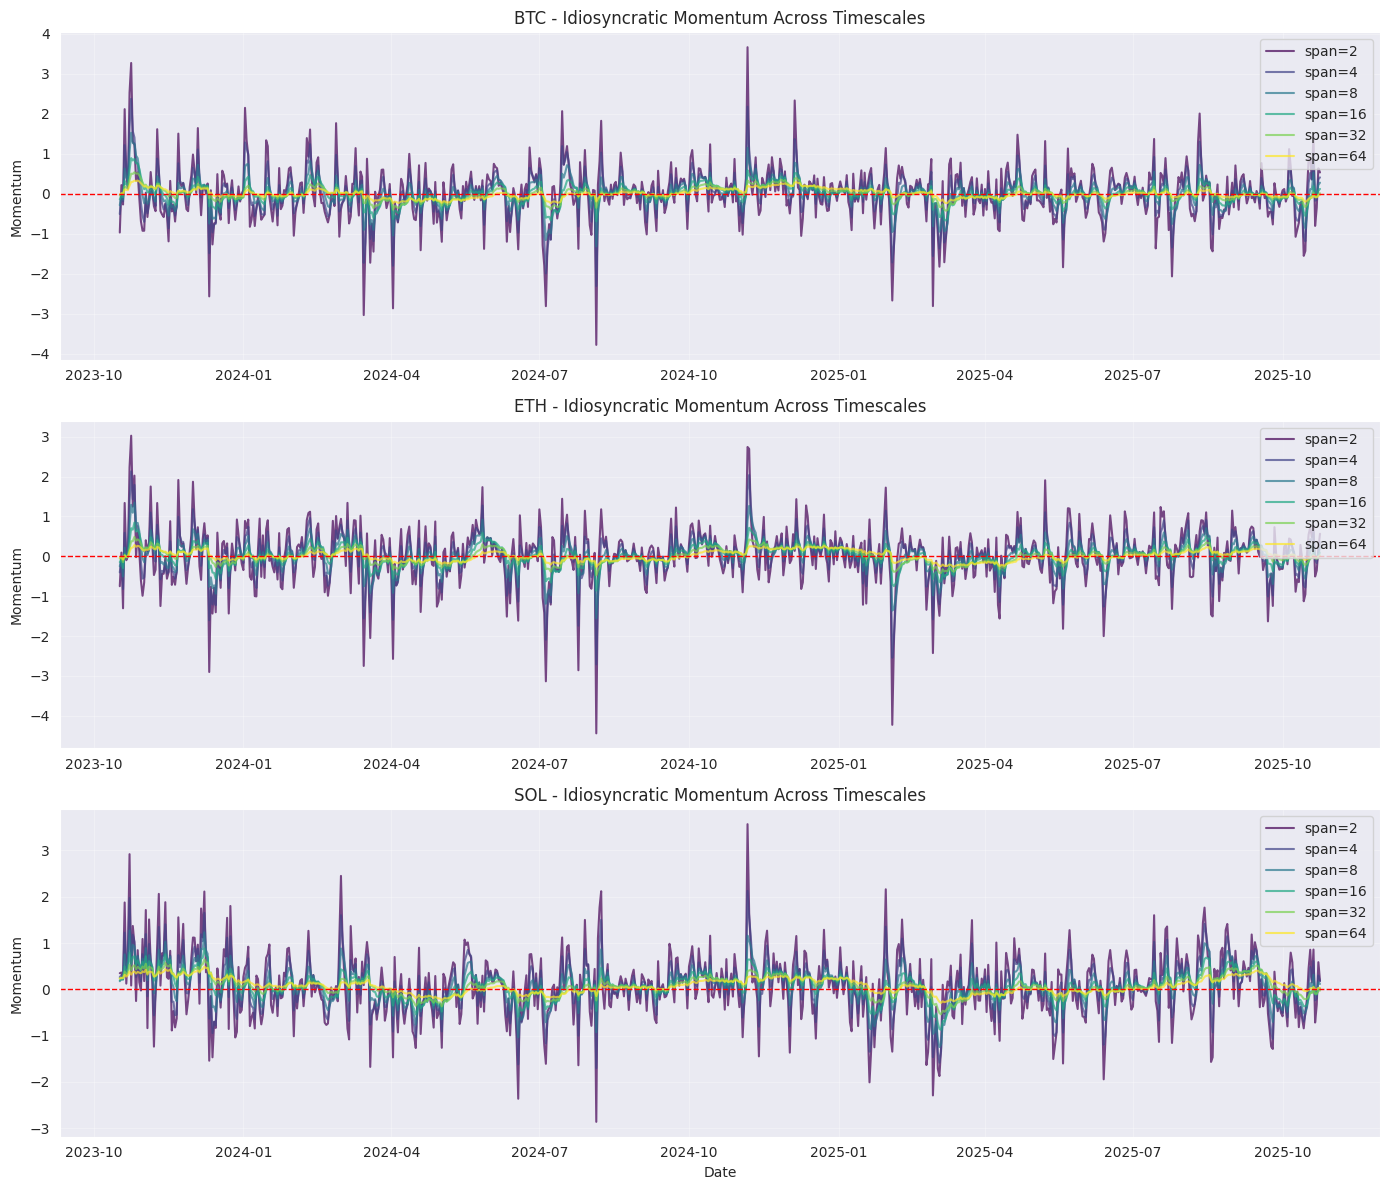

In [6]:
# Select sample assets
sample_assets = ['BTC', 'ETH', 'SOL']
available_assets = [a for a in sample_assets if a in momentum_panel.index.get_level_values('asset').unique()]

if not available_assets:
    available_assets = momentum_panel.index.get_level_values('asset').unique()[:3]

# Plot momentum for each asset across all spans
fig, axes = plt.subplots(len(available_assets), 1, figsize=(14, 4 * len(available_assets)))

if len(available_assets) == 1:
    axes = [axes]

spans = sorted(momentum_panel.index.get_level_values('span').unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(spans)))

for i, asset in enumerate(available_assets):
    for span, color in zip(spans, colors):
        # Extract momentum for this asset and span
        mom_data = momentum_panel.xs((asset, span), level=('asset', 'span'))
        
        axes[i].plot(
            mom_data.index,
            mom_data['momentum'],
            label=f'span={span}',
            alpha=0.7,
            linewidth=1.5,
            color=color
        )
    
    axes[i].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[i].set_title(f'{asset} - Idiosyncratic Momentum Across Timescales')
    axes[i].set_ylabel('Momentum')
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

## 4. Fast vs Slow Momentum Comparison

Compare fast momentum (span=2) vs slow momentum (span=32) for regime detection.

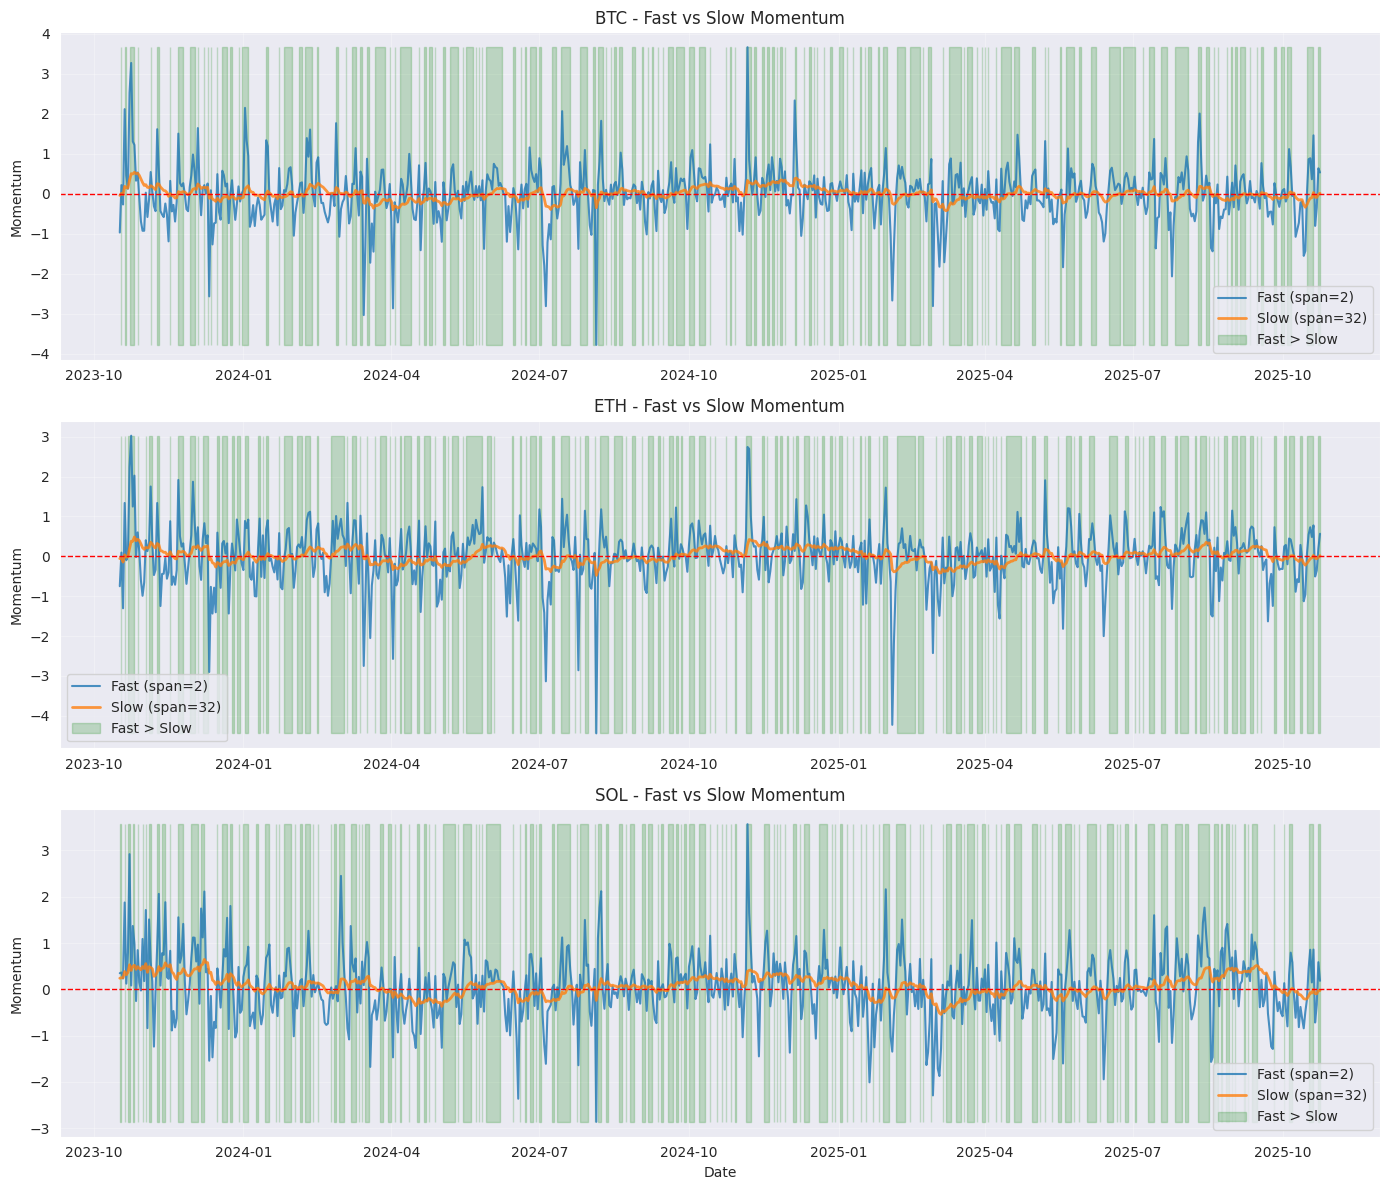

In [7]:
# Extract fast and slow momentum
mom_fast = momentum_panel.xs(2, level='span')['momentum'].unstack(level='asset')
mom_slow = momentum_panel.xs(32, level='span')['momentum'].unstack(level='asset')

# Plot for sample assets
fig, axes = plt.subplots(len(available_assets), 1, figsize=(14, 4 * len(available_assets)))

if len(available_assets) == 1:
    axes = [axes]

for i, asset in enumerate(available_assets):
    if asset in mom_fast.columns and asset in mom_slow.columns:
        axes[i].plot(mom_fast.index, mom_fast[asset], label='Fast (span=2)', linewidth=1.5, alpha=0.8)
        axes[i].plot(mom_slow.index, mom_slow[asset], label='Slow (span=32)', linewidth=2, alpha=0.8)
        axes[i].axhline(0, color='red', linestyle='--', linewidth=1)
        
        # Highlight fast > slow regions (bullish crossover)
        crossover = mom_fast[asset] > mom_slow[asset]
        axes[i].fill_between(
            mom_fast.index,
            mom_fast[asset].min(),
            mom_fast[asset].max(),
            where=crossover,
            alpha=0.2,
            color='green',
            label='Fast > Slow'
        )
        
        axes[i].set_title(f'{asset} - Fast vs Slow Momentum')
        axes[i].set_ylabel('Momentum')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

## 5. Cross-Sectional Analysis

Analyze momentum distribution across assets at a specific timestamp.

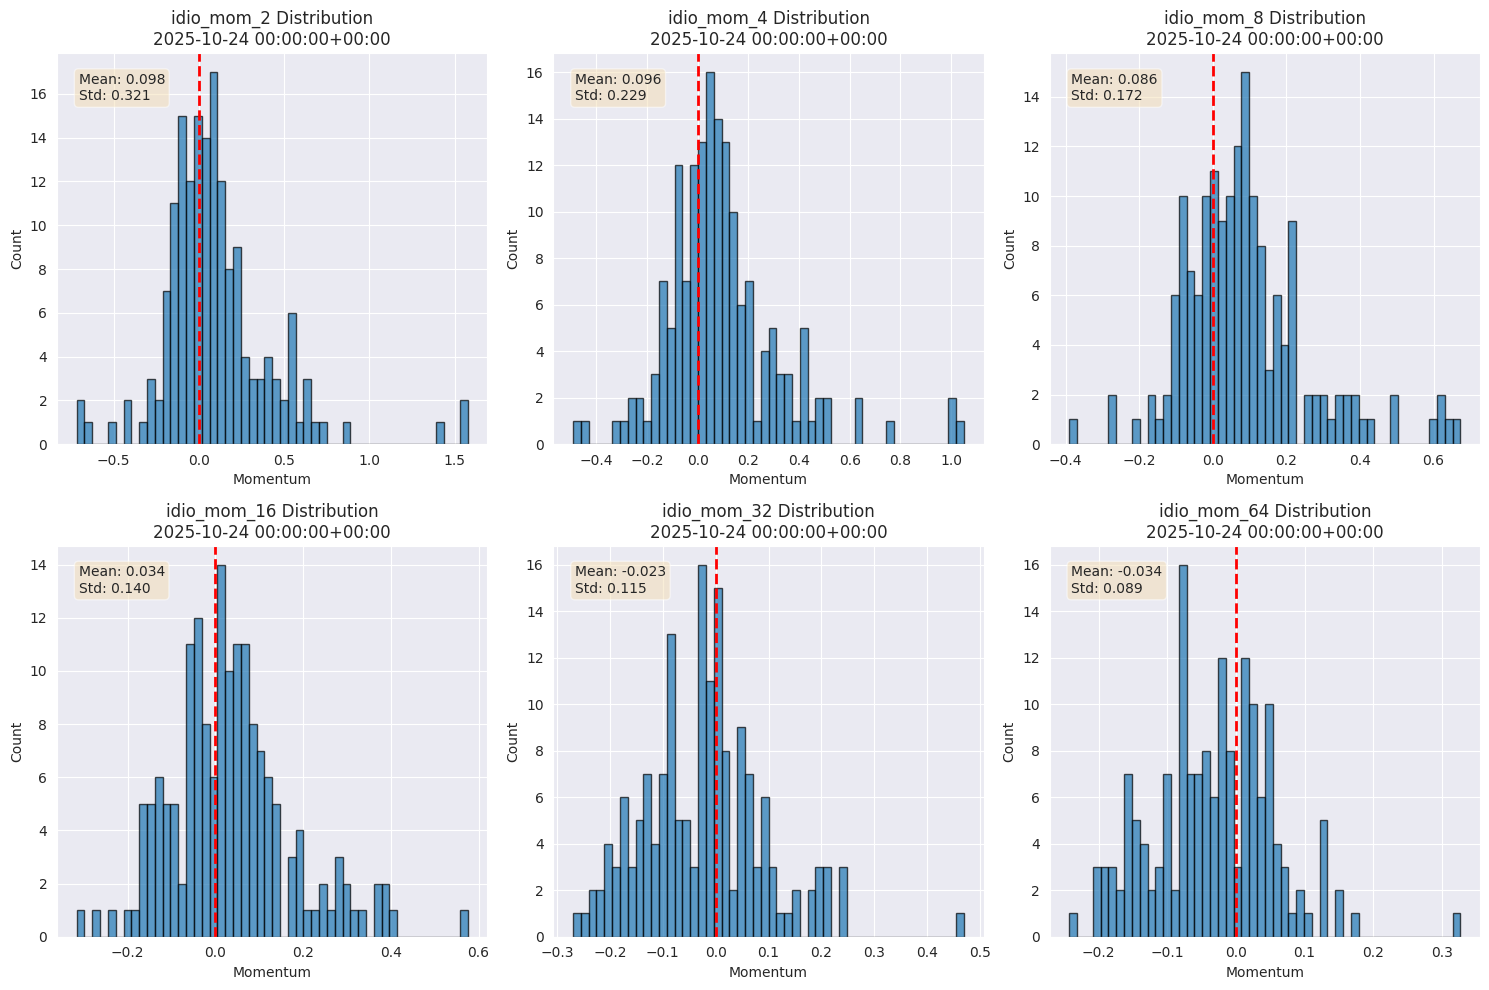

In [8]:
# Get most recent timestamp
recent_ts = momentum_panel.index.get_level_values('timestamp').max()

# Extract cross-section for each span
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

spans = sorted(momentum_panel.index.get_level_values('span').unique())

for i, span in enumerate(spans):
    cross_section = momentum_panel.xs((recent_ts, span), level=('timestamp', 'span'))['momentum']
    cross_section = cross_section.sort_values(ascending=False)
    
    axes[i].hist(cross_section.values, bins=50, alpha=0.7, edgecolor='black')
    axes[i].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[i].set_title(f'idio_mom_{span} Distribution\n{recent_ts}')
    axes[i].set_xlabel('Momentum')
    axes[i].set_ylabel('Count')
    axes[i].text(
        0.05, 0.95,
        f'Mean: {cross_section.mean():.3f}\nStd: {cross_section.std():.3f}',
        transform=axes[i].transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    )

plt.tight_layout()
plt.show()

## 6. Momentum Span Correlation Analysis

Analyze correlation structure between different momentum timescales.

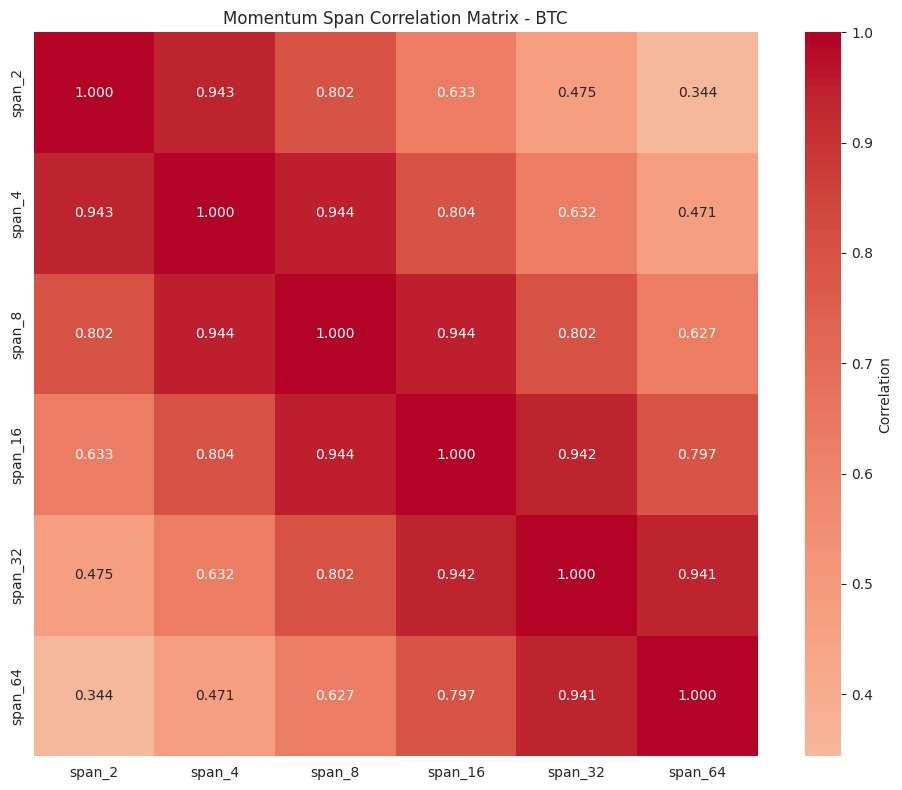


Correlation insights:
- High correlation between adjacent spans (expected)
- Lower correlation between fast and slow spans (regime shifts)
- Can be used for feature selection/regularization


In [9]:
# Create wide format with spans as columns for a sample asset
sample_asset = available_assets[0]

# Extract all spans for this asset
asset_momentum = momentum_panel.xs(sample_asset, level='asset')['momentum'].unstack(level='span')
asset_momentum.columns = [f'span_{s}' for s in asset_momentum.columns]

# Compute correlation matrix
corr_matrix = asset_momentum.corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    square=True,
    ax=ax,
    cbar_kws={'label': 'Correlation'}
)
ax.set_title(f'Momentum Span Correlation Matrix - {sample_asset}')
plt.tight_layout()
plt.show()

print("\nCorrelation insights:")
print("- High correlation between adjacent spans (expected)")
print("- Lower correlation between fast and slow spans (regime shifts)")
print("- Can be used for feature selection/regularization")

## 7. Convert to Wide Format for Modeling

Pivot momentum panel into wide format suitable for ML models.

In [10]:
# Pivot to wide format: (timestamp, asset) -> features
momentum_wide = momentum_panel['momentum'].unstack(level='span')
momentum_wide.columns = [f'idio_mom_{s}' for s in momentum_wide.columns]

print(f"Wide momentum panel shape: {momentum_wide.shape}")
print(f"Columns: {list(momentum_wide.columns)}")
print(f"\nSample:")
print(momentum_wide.head(10))

# Check for NaN coverage
print(f"\nNaN percentage per feature:")
print((momentum_wide.isna().sum() / len(momentum_wide) * 100).round(2))

Wide momentum panel shape: (82739, 6)
Columns: ['idio_mom_2', 'idio_mom_4', 'idio_mom_8', 'idio_mom_16', 'idio_mom_32', 'idio_mom_64']

Sample:
                                 idio_mom_2  idio_mom_4  idio_mom_8  \
timestamp                 asset                                       
2023-10-17 00:00:00+00:00 AAVE    -0.378772   -0.092686   -0.020057   
                          ADA     -0.329124   -0.158428   -0.162481   
                          APE      0.561321    0.494503    0.336201   
                          APT      0.409057    0.144377   -0.079592   
                          ARB     -0.292875   -0.065789   -0.043977   
                          ATOM    -0.491173   -0.225269   -0.180179   
                          AVAX    -0.117565    0.156305    0.147009   
                          BCH     -0.676721   -0.338135   -0.209533   
                          BLUR    -0.427738   -0.155557   -0.115224   
                          BNB     -0.503306   -0.210081   -0.133131   

   

## 8. Export Features

Save momentum panel for use in modeling notebooks.

In [11]:
# Export both long and wide formats
output_dir = Path('../data/features')

# Long format (timestamp, asset, span)
momentum_panel.reset_index().to_parquet(
    output_dir / 'momentum_panel_long.parquet',
    index=False
)

# Wide format (timestamp, asset) with feature columns
momentum_wide.reset_index().to_parquet(
    output_dir / 'momentum_panel_wide.parquet',
    index=True
)

print(f"✓ Exported momentum features to {output_dir}")
print(f"  - momentum_panel_long.parquet ({momentum_panel.shape})")
print(f"  - momentum_panel_wide.parquet ({momentum_wide.shape})")

✓ Exported momentum features to ../data/features
  - momentum_panel_long.parquet ((496434, 1))
  - momentum_panel_wide.parquet ((82739, 6))


## Summary

**Momentum Panel Created:**
- ✓ Multi-timescale EWMA momentum (spans: 2, 4, 8, 16, 32, 64)
- ✓ Volatility-normalized for comparability
- ✓ Panel structure: (timestamp, asset, span)
- ✓ Exported in both long and wide formats

**Next Steps:**
1. Use momentum panel as features for return prediction model
2. Test predictive power of each span
3. Combine with other features (funding rates, volume, etc.)
4. Train models for different holding periods H
5. Implement portfolio construction with predicted alphas